In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%tensorflow_version

Currently selected TF version: 1.x
Available versions:
* 1.x
* 2.x


In [3]:
from IPython.display import clear_output
!git clone https://github.com/matterport/Mask_RCNN.git # load Mask R-CNN code implementation
# !git clone https://github.com/ruslan-kl/brain-tumor.git # load new data set and annotations!pip install pycocotools
# !rm -rf brain-tumor/.git/
!rm -rf Mask_RCNN/.git/clear_output()

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `rm -rf Mask_RCNN/.git/clear_output()'


In [4]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import tensorflow

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN/")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline

Using TensorFlow backend.


In [5]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [6]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = '/content/drive/My Drive/brain_tumor_dataset/yes_cleaned/' # directory with image data
DEFAULT_LOGS_DIR = 'logs'# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [7]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [8]:
class TumorConfig(coco.CocoConfig):
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# pip install split-folders

In [30]:
# import split_folders

# split_folders.ratio('/content/drive/My Drive/brain_tumor_dataset/yes_cleaned/', output="/content/drive/My Drive/brain_tumor_dataset/output_split/", ratio=(.8, .1, .1))

In [31]:
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# # yes_images = os.listdir('/content/drive/My Drive/brain_tumor_dataset/yes_cleaned')
# # split_data = []
# # with tensorflow.device('/device:GPU:0'):
# #   for image in yes_images:
# #     img = cv2.imread('/content/drive/My Drive/brain_tumor_dataset/yes_cleaned/' + image)
# #     img = img_to_array(img)
# #     # face = cv2.resize(img, (256, 256))
# #     # (b, g, r)=cv2.split(img) 
# #     # img=cv2.merge([r,g,b])
# #     split_data.append(face)

# # d = np.squeeze(split_data)
# # d.shape

# # # normalize data
# # d = d.astype('float32')
# # d /= 255

# yes_image_path = '/content/drive/My Drive/brain_tumor_dataset/yes_cleaned'
# data = []
# for img in os.listdir(yes_image_path):
#     img = cv2.imread(yes_image_path + '\\' + img)
#     # img = img_to_array(img)
#     img = cv2.resize(img, (256, 256))
# #     img = img.reshape((1,) + img.shape)
#     data.append(img)

In [32]:
# def split_data(X, test_size=0.2):

    
#     train, test_val = train_test_split(X, test_size=test_size)
#     test, val = train_test_split(test_val, test_size=0.5)
    
#     return train, val, test

In [33]:
# from sklearn.model_selection import train_test_split

# train, val, test  = split_data(d, test_size=0.4)
# # test_dataset, training_dataset = train_test_split(d, train_size=5, test_size=5)

In [34]:
# import os
# import numpy as np
# import shutil

# # # Creating Train / Val / Test folders (One time use)
# root_dir = '/content/drive/My Drive/brain_tumor_dataset'
# # posCls = '/DPN+'
# # negCls = '/DPN-'

# os.makedirs(root_dir +'/train')
# # os.makedirs(root_dir +'/train' + negCls)
# os.makedirs(root_dir +'/val')
# # os.makedirs(root_dir +'/val' + negCls)
# os.makedirs(root_dir +'/test')
# # os.makedirs(root_dir +'/test' + negCls)

# # Creating partitions of the data after shuffeling
# # currentCls = posCls
# src = '/content/drive/My Drive/brain_tumor_dataset/yes_cleaned' # Folder to copy images from

# allFileNames = os.listdir(src)
# np.random.shuffle(allFileNames)
# train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                           [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


# train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
# val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
# test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

# print('Total images: ', len(allFileNames))
# print('Training: ', len(train_FileNames))
# print('Validation: ', len(val_FileNames))
# print('Testing: ', len(test_FileNames))

# # Copy-pasting images
# for name in train_FileNames:
#     shutil.copy(name, "/content/drive/My Drive/brain_tumor_dataset/train")

# for name in val_FileNames:
#     shutil.copy(name, "/content/drive/My Drive/brain_tumor_dataset/val")

# for name in test_FileNames:
#     shutil.copy(name, "/content/drive/My Drive/brain_tumor_dataset/test")

In [35]:
# import os
# import numpy as np
# import shutil

# # # Creating Train / Val / Test folders (One time use)
# root_dir = '/content/drive/My Drive/brain_tumor_dataset/yes_cleaned'
# # posCls = '/DPN+'
# # negCls = '/DPN-'

# os.makedirs(root_dir +'/train')
# # os.makedirs(root_dir +'/train' + negCls)
# os.makedirs(root_dir +'/val')
# # os.makedirs(root_dir +'/val' + negCls)
# os.makedirs(root_dir +'/test')
# # os.makedirs(root_dir +'/test' + negCls)

# # Creating partitions of the data after shuffeling
# # currentCls = posCls
# src = '/content/drive/My Drive/brain_tumor_dataset/yes_cleaned' # Folder to copy images from

# allFileNames = os.listdir(src)
# np.random.shuffle(allFileNames)
# train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
#                                                           [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])


# train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
# val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
# test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

# print('Total images: ', len(allFileNames))
# print('Training: ', len(train_FileNames))
# print('Validation: ', len(val_FileNames))
# print('Testing: ', len(test_FileNames))

# # Copy-pasting images
# for name in train_FileNames:
#     shutil.copy(name, "/content/drive/My Drive/brain_tumor_dataset/train")

# for name in val_FileNames:
#     shutil.copy(name, "/content/drive/My Drive/brain_tumor_dataset/val")

# for name in test_FileNames:
#     shutil.copy(name, "/content/drive/My Drive/brain_tumor_dataset/test")

In [36]:
# def save_new_images(X, dir_name):
#     for (i,img) in enumerate(X):
#         img= array_to_img(img)
#         cv2.imwrite(dir_name+'/'+str(i)+'.jpg', img)

In [37]:
# save_new_images(train, '/content/yes_cleaned/train/')

In [14]:
class BrainScanDataset(utils.Dataset):
  def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")# Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annot_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys# The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]# Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]# load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )
  def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)# Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1# Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
  def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [15]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [16]:
!pip install simplejson
import simplejson as json

In [17]:
with tensorflow.device('/device:GPU:0'):
  # Training dataset.
  dataset_train = BrainScanDataset()
  dataset_train.load_brain_scan(DATASET_DIR, 'train')
  dataset_train.prepare()# Validation dataset
  dataset_val = BrainScanDataset()
  dataset_val.load_brain_scan(DATASET_DIR, 'val')
  dataset_val.prepare()
  dataset_test = BrainScanDataset()
  dataset_test.load_brain_scan(DATASET_DIR, 'test')
  dataset_test.prepare()
  print("Training network heads")
  model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=15,
    layers='heads'
  )

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20200701T2027/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

In [18]:
def predict_and_plot_differences(dataset, img_id):
  original_image, image_meta, gt_class_id, gt_box, gt_mask =\
  modellib.load_image_gt(dataset, config, img_id, use_mini_mask=False)
  results = model.detect([original_image], verbose=0)
  r = results[0]
  
  visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)
    
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

In [19]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

model_path = model.find_last()# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  logs/tumor_detector20200701T2027/mask_rcnn_tumor_detector_0015.h5
Re-starting from epoch 15


In [20]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [21]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)    
    results = model.detect([original_image], verbose=0)
    r = results[0]    
    
    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_ax(),
        show_mask=True, show_box=True)
    
def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

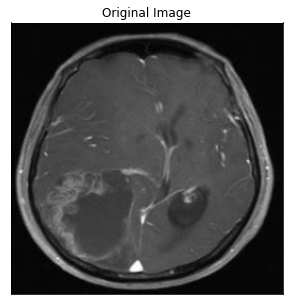

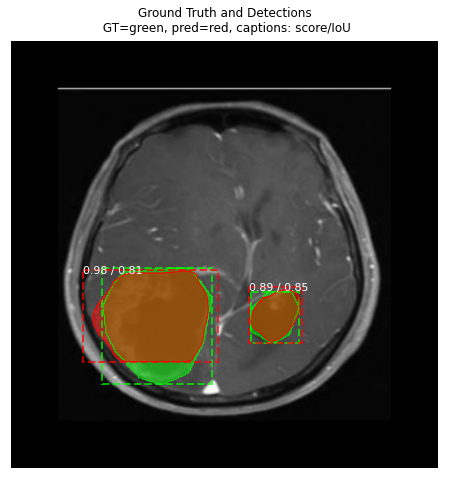

In [24]:
ind = 6
display_image(dataset_val, ind)
predict_and_plot_differences(dataset_val, ind)

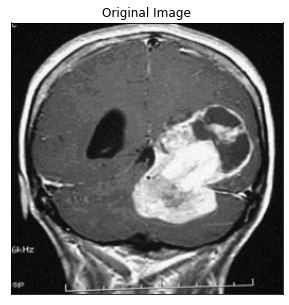

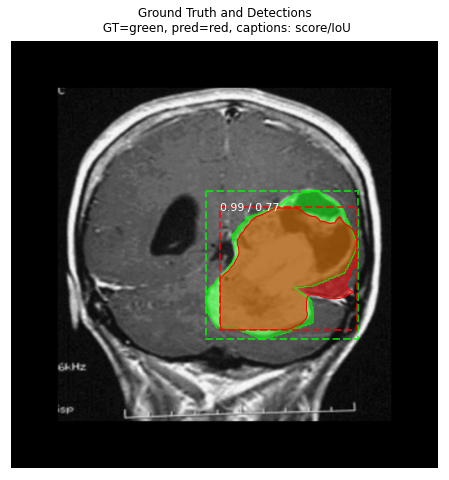

In [26]:
#Test Set
ind = 1
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

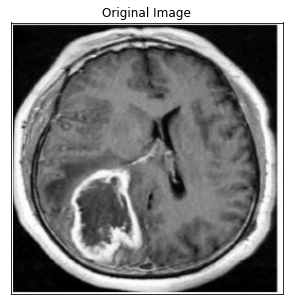

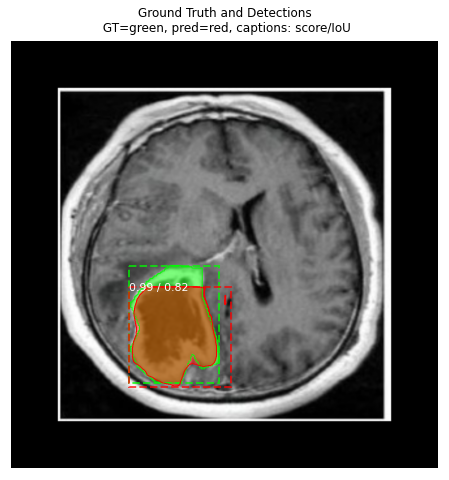

In [27]:
#Test Set
ind = 2
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

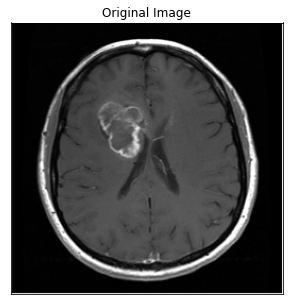

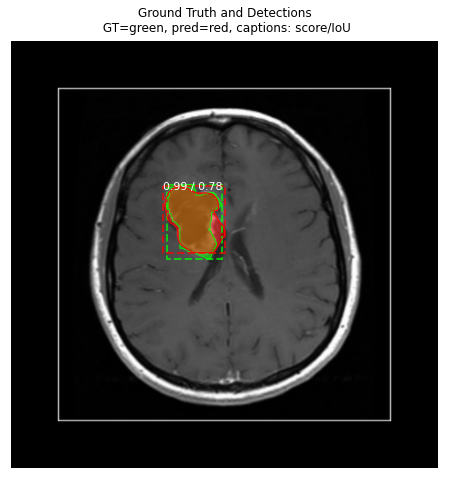

In [28]:
ind = 0
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)

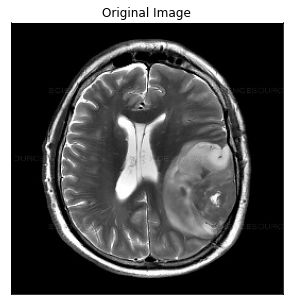

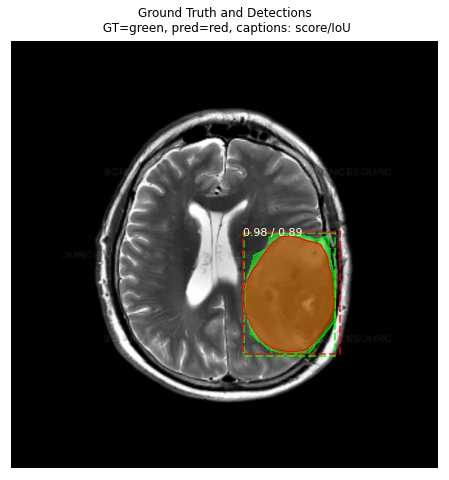

In [41]:
#Test Set
ind = 7
display_image(dataset_test, ind)
predict_and_plot_differences(dataset_test, ind)